This time we try some feature engineering on the text fields and combine the results with the otehr numerical columns.

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcdefaults()
mpl.style.use('additional')

def print_df_max_colwidth(df, width=200):
    with pd.option_context('display.max_colwidth', width):
        print(df)

# Warmup

In [3]:
train_df = pd.read_json("train.json")
test_df = pd.read_json("test.json")
train_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.500000,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.714500,7211212,-73.942500,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.000000,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.794700,7150865,-73.966700,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.000000,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.738800,6887163,-74.001800,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.000000,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.753900,6888711,-73.967700,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.000000,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.824100,6934781,-73.949300,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


Redo feature engineering and random forest model.

In [35]:
def engineer_features1(df):
    price_max = np.percentile(df.price, 99)
    df.loc[df.price > price_max, 'price'] = price_max
    latitude_max = np.percentile(df.latitude, 99)
    latitude_min = np.percentile(df.latitude, 1)
    df.loc[df.latitude > latitude_max, 'latitude'] = latitude_max
    df.loc[df.latitude < latitude_min, 'latitude'] = latitude_min
    longitude_max = np.percentile(df.longitude, 99)
    longitude_min = np.percentile(df.longitude, 1)
    df.loc[df.longitude > longitude_max, 'longitude'] = longitude_max
    df.loc[df.longitude < longitude_min, 'longitude'] = longitude_min
    df["num_photos"] = df.photos.apply(len)
    df["num_features"] = df.features.apply(len)
    df["num_description_words"] = df.description.apply(lambda x: len(x.split(" ")))
    df["created"] = pd.to_datetime(df.created)
    df["created_year"] = df.created.dt.year
    df["created_month"] = df.created.dt.month
    df["created_day"] = df.created.dt.day

engineer_features1(train_df)
engineer_features1(test_df)

In [44]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from sklearn.feature_extraction.text import CountVectorizer

X_vars = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 'num_photos', 'num_features', 'num_description_words', 'created_year', 'created_month', 'created_day']
X_train, X_test, y_train, y_test = train_test_split(train_df[X_vars], train_df['interest_level'], stratify=train_df['interest_level'])

In [ ]:
n_estimators = np.logspace(1, 3, 5).astype(int)
rf = GridSearchCV(RandomForestClassifier(n_jobs=-1), {'n_estimators': n_estimators},
                 scoring='neg_log_loss').fit(X_train, y_train)

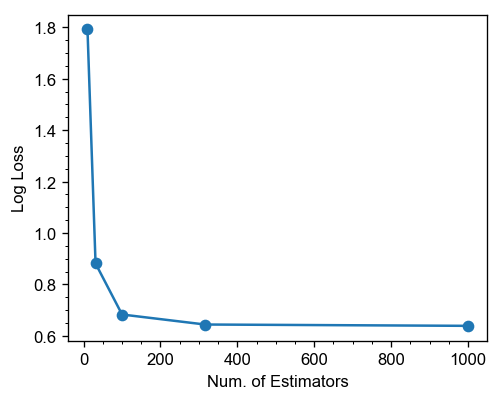

In [48]:
rf_cv_results = pd.DataFrame(rf.cv_results_)
plt.plot(rf_cv_results['param_n_estimators'], -rf_cv_results['mean_test_score'], '-o')
plt.xlabel('Num. of Estimators')
plt.ylabel('Log Loss')

Looks like 400 estimators are enough.

In [45]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=400).fit(X_train, y_train)
y_probs_pred = rf.predict_proba(X_test)
print(log_loss(y_test, y_probs_pred))

0.644007760717


More feature engineering.

In [36]:
def engineer_features2(df):
    df['all_rooms'] = df['bathrooms'] + df['bedrooms']
    df['price_per_bed'] = df['price'] / df['bedrooms']    
    df['price_per_bath'] = df['price'] / df['bathrooms']
    df['price_per_room'] = df['price'] / df['all_rooms']

    df['price_per_bed'] = df['price_per_bed'].replace(np.Inf, 5000)
    df['price_per_bath'] = df['price_per_bath'].replace(np.Inf, 5000)
    df['price_per_room'] = df['price_per_room'].replace(np.Inf, 5000)
    
engineer_features2(train_df)
engineer_features2(test_df)

In [46]:
X_vars1 = X_vars + ['all_rooms', 'price_per_bed', 'price_per_bath', 'price_per_room']
X_train, X_test, y_train, y_test = train_test_split(train_df[X_vars1], train_df['interest_level'], stratify=train_df['interest_level'])

In [47]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=1000).fit(X_train, y_train)
y_probs_pred = rf.predict_proba(X_test)
print(log_loss(y_test, y_probs_pred))

0.636847919769


Hmmm... Only minimal improvement.

# Text Processing

## `features` Field

Try vectorizing the feature words. First look at the non-text characters.

In [105]:
train_df.features_clean.str.extractall('(\W)')[0].unique()

array([' ', '-', '/', '(', ')', '*', '\xa0', '&', '!', "'", '.', ':', '•',
       '’', '$', '~', ';', '@', '^', '+', '<', '>', '"', '®'], dtype=object)

In [7]:
from itertools import chain

def features_cleanup_star(x):
    return list(chain.from_iterable(re.sub(r'\s*\*+\s*\**\s*', r'*', i).strip('*').split('*') for i in x))

def process_features(df):
    df['features_clean'] = df['features']\
                    .apply(lambda x: ' '.join([re.sub(r'\W', '', i) for i in x]).lower())

    df.loc[df.features_clean.str.contains('\*'), 'features_clean'] = \
            df.loc[df.features_clean.str.contains('\*'), 'features']\
                    .apply(features_cleanup_star)\
                    .apply(lambda x: ' '.join([re.sub(r'\W', '', i) for i in x]).lower())
                
process_features(train_df)
process_features(test_df)

In [194]:
?CountVectorizer(stop_words='english', max_features=200)

In [9]:
countvec_features = CountVectorizer(stop_words='english', max_features=200)
countvec_features.fit(train_df['features_clean'].tolist() + test_df['features_clean'].tolist())
train_df_features = countvec_features.transform(train_df['features_clean'])
test_df_features = countvec_features.transform(test_df['features_clean'])

In [10]:
countvec_features.vocabulary_

{'247concierge': 0,
 '247doorman': 1,
 '247doormanconcierge': 2,
 '24hourdoorman': 3,
 'actualaptphotos': 4,
 'airconditioning': 5,
 'allutilitiesincluded': 6,
 'assignedparkingspace': 7,
 'attendedlobby': 8,
 'backyard': 9,
 'balcony': 10,
 'basementstorage': 11,
 'bikeroom': 12,
 'bikestorage': 13,
 'billiardsroom': 14,
 'breakfastbar': 15,
 'brownstone': 16,
 'buildingcommonoutdoorspace': 17,
 'businesscenter': 18,
 'cablesatellitetv': 19,
 'calltextabrahamcaro9173730862': 20,
 'catsallowed': 21,
 'centralac': 22,
 'centralair': 23,
 'chefskitchen': 24,
 'childrensplayroom': 25,
 'cityview': 26,
 'closetosubway': 27,
 'closetsgalore': 28,
 'commonbackyard': 29,
 'commongarden': 30,
 'commonoutdoorspace': 31,
 'commonparkinggarage': 32,
 'commonroofdeck': 33,
 'commonterrace': 34,
 'communityrecreationfacilities': 35,
 'complimentarysundaybrunch': 36,
 'concierge': 37,
 'conciergeservice': 38,
 'condofinishes': 39,
 'courtyard': 40,
 'deck': 41,
 'decorativefireplace': 42,
 'diningro

In [48]:
X_train, X_test, y_train, y_test = train_test_split(train_df_features, train_df['interest_level'], stratify=train_df['interest_level'])
rf = RandomForestClassifier(n_jobs=-1, n_estimators=500).fit(X_train, y_train)
y_probs_pred = rf.predict_proba(X_test)
print(log_loss(y_test, y_probs_pred))

1.051382209


In [49]:
train_df_combined = np.column_stack([train_df[X_vars1], train_df_features.todense()])
X_train, X_test, y_train, y_test = train_test_split(train_df_combined, train_df['interest_level'], stratify=train_df['interest_level'])

In [50]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=500).fit(X_train, y_train)
y_probs_pred = rf.predict_proba(X_test)
print(log_loss(y_test, y_probs_pred))

0.606495224603


Small improvement.

## `description` Field

In [11]:
countvec_desc = CountVectorizer(stop_words='english', max_features=200)
countvec_desc.fit(train_df['description'].tolist() + test_df['description'].tolist())
train_df_desc = countvec_desc.transform(train_df['description'])
test_df_desc = countvec_desc.transform(test_df['description'])

In [12]:
countvec_desc.vocabulary_

{'24': 0,
 '_blank': 1,
 'access': 2,
 'amazing': 3,
 'amenities': 4,
 'amp': 5,
 'apartment': 6,
 'apartments': 7,
 'appliances': 8,
 'appointment': 9,
 'area': 10,
 'art': 11,
 'available': 12,
 'away': 13,
 'bars': 14,
 'bath': 15,
 'bathroom': 16,
 'bathrooms': 17,
 'beautiful': 18,
 'bed': 19,
 'bedroom': 20,
 'bedrooms': 21,
 'best': 22,
 'block': 23,
 'blocks': 24,
 'bond': 25,
 'br': 26,
 'brand': 27,
 'brick': 28,
 'bright': 29,
 'broker': 30,
 'building': 31,
 'cabinets': 32,
 'ceiling': 33,
 'ceilings': 34,
 'center': 35,
 'central': 36,
 'city': 37,
 'close': 38,
 'closet': 39,
 'closets': 40,
 'com': 41,
 'concierge': 42,
 'contact': 43,
 'coopercooper': 44,
 'counter': 45,
 'countertops': 46,
 'custom': 47,
 'deal': 48,
 'deck': 49,
 'dining': 50,
 'dishwasher': 51,
 'doorman': 52,
 'dryer': 53,
 'east': 54,
 'easy': 55,
 'elevator': 56,
 'email': 57,
 'enjoy': 58,
 'equal': 59,
 'estate': 60,
 'exclusive': 61,
 'exposed': 62,
 'features': 63,
 'fee': 64,
 'feel': 65,
 'f

In [51]:
train_df_combined = np.column_stack([train_df[X_vars1], train_df_features.todense(), train_df_desc.todense()])
X_train, X_test, y_train, y_test = train_test_split(train_df_combined, train_df['interest_level'], stratify=train_df['interest_level'])

In [52]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=500).fit(X_train, y_train)
y_probs_pred = rf.predict_proba(X_test)
print(log_loss(y_test, y_probs_pred))

0.621021205792


Apparently slightly worse. This level of deviation could be noice.

# Boosting

Try `GradientBoostingClassifier` in `scikit-learn`.

In [21]:
# params = {'learning_rate': [0.05, 0.1, 0.2], 'subsample': [1, 0.5]}
# gbc = GridSearchCV(GradientBoostingClassifier(n_estimators=1000), 
#                          params, scoring='neg_log_loss').fit(X_train, y_train)

gbc = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, subsample=0.5).fit(X_train, y_train)
y_probs_pred = gbc.predict_proba(X_test)
print(log_loss(y_test, y_probs_pred))

0.581470890804


Now try `xgboost`.

In [ ]:
import xgboost as xgb

def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=1000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

target_num_map = {'high':0, 'medium':1, 'low':2}
X_train, X_test, y_train, y_test = train_test_split(train_df_combined, train_df['interest_level'].apply(lambda x: target_num_map[x]), stratify=train_df['interest_level'])
preds, model = runXGB(X_train, y_train, X_test, num_rounds=400)
print(log_loss(y_test, preds))

Result is faster and slightly better. So far the best model.

In [37]:
test_df_combined = np.column_stack([test_df[X_vars1], test_df_features.todense(), test_df_desc.todense()])
test_y = model.predict(xgb.DMatrix(test_df_combined))

In [43]:
pd.DataFrame(test_y, index=test_df.listing_id, columns=['high', 'medium', 'low']).to_csv('submission_xgb.csv')